#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa. 
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt** 
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
from collections import Counter
import numpy as np

from decimal import *

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [2]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

x = iris.data
y = iris.target


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


class NaiveBayes:
    def __init__(self, x_train, y_train):
        self.priors = {}
        self.likelihoods = {}
        self.intervals = {}

        self.num_samples = x_train.shape[0]
        self.num_features = x_train.shape[1]

        self.classes = set(y_train)

        self.train_features = x_train
        self.train_classes = y_train

    def build_classifier(self):

        #calc probability of class appearance in y_train
        #calc priors
        class_count = Counter(self.train_classes)
        for cl in class_count:
            self.priors[cl] = class_count[cl] / self.num_samples

        #calc likelihoods
        self.data_discretization()

    @staticmethod
    def split_data(feature_values, intervals):
        return np.digitize(feature_values, intervals) - 1

    def data_discretization(self):
        for cl in self.classes:
            for feature in range(self.num_features):
                feature_values = self.train_features[self.train_classes == cl, feature] #wybór tylko samplów danej klasy
                # a następnie wybieranie danego feature
                #self.likelihoods[cl, feature] = Counter(self.data_discretization(feature_values, cl, feature))
                intervals = np.linspace(0, feature_values.max(), 4)
                self.intervals[cl, feature] = intervals
                self.likelihoods[cl, feature] = Counter(self.split_data(feature_values, intervals)) #minus jeden aby zwracało klasy 0->3
        

    def predict(self, sample):
        predictions = {}
        for cl in self.classes:
            likelihood = 1
            for feature in range(self.num_features):
                feature_values = self.split_data(sample[feature], self.intervals[cl, feature])
                likelihood *= self.likelihoods[cl, feature][feature_values] / sum(self.likelihoods[cl, feature].values())
            predictions[cl] = likelihood * self.priors[cl]
        
        max_value = 0
        max_key = 0
        for key in predictions:
            if predictions[key] > max_value:
                max_key = key
                max_value = predictions[key]
        return max_key    


class GaussianNaiveBayes:
    def __init__(self, x_train, y_train):
        self.priors = {}
        self.likelihoods = {}

        self.num_samples = x_train.shape[0]
        self.num_features = x_train.shape[1]

        self.classes = set(y_train)

        self.train_features = x_train
        self.train_classes = y_train

    def build_classifier(self):
        #calc priors
        class_count = Counter(self.train_classes)
        for cl in class_count:
            self.priors[cl] = class_count[cl] / self.num_samples
        
        #calc likelihoods
        for cl in self.classes:
            current_class_rows = [i for i, x in enumerate(self.train_classes) if x == cl]
            current_class_features = self.train_features[current_class_rows]

            self.likelihoods[cl] = {}
            for feature in range(self.num_features):
                self.likelihoods[cl][feature] = (current_class_features[:, feature].mean(), current_class_features[:, feature].std())

    @staticmethod
    def normal_dist(x, mean, std):
        exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(std,2))))
        return (1 / (math.sqrt(2*math.pi) * std)) * exponent

    def predict(self, sample):
        predictions = {}
        for cl in self.classes:
            likelihood = 1
            for feature in range(self.num_features):
                mean, std = self.likelihoods[cl][feature]
                likelihood *= self.normal_dist(sample[feature], mean, std)
            predictions[cl] = likelihood * self.priors[cl]
            
        max_value = 0
        max_key = 0
        for key in predictions:
            if predictions[key] > max_value:
                max_key = key
                max_value = predictions[key]
        return max_key



## NaiveBayes

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

nb = NaiveBayes(x_train, y_train)
nb.build_classifier()
y_pred = [nb.predict(x) for x in x_test]

acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]
Accuracy:  1.0
Errors: 0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=123)

nb = NaiveBayes(x_train, y_train)
nb.build_classifier()
y_pred = [nb.predict(x) for x in x_test]

acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 2 0 2 0 0 0 2 2 0 2 2 0 0 1 1 2
 0 0 1 1 0 2 2 2 2 2 1 0 0 2 0 0 1 1 1 1 2 1 2]
Accuracy:  0.9833333333333333
Errors: 1


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=232)

nb = NaiveBayes(x_train, y_train)
nb.build_classifier()
y_pred = [nb.predict(x) for x in x_test]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 0]
[1 0 0 0 2 1 2 1 1 1 1 0 2 1 0]
Accuracy:  0.9333333333333333
Errors: 1


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=232)

nb = NaiveBayes(x_train, y_train)
nb.build_classifier()
y_pred = [nb.predict(x) for x in x_test]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0]
[1 0 0 0 2 1 2 1 1 1 1 0 2 1 0 2 2 1 2 1 2 1 1 1 1 2 1 1 1 0 2 2 1 0 2 0 0
 0 0 2 2 1 2 0 2 1 2 1 0 1 0 0 0 0 0 2 1 0 2 0]
Accuracy:  0.95
Errors: 3


## GuassianNaiveBayes

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

gb = GaussianNaiveBayes(x_train, y_train)
gb.build_classifier()
y_pred = [gb.predict(x) for x in x_test]

acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]
Accuracy:  1.0
Errors: 0


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=123)

gb = GaussianNaiveBayes(x_train, y_train)
gb.build_classifier()
y_pred = [gb.predict(x) for x in x_test]

acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 2 0 2 0 0 0 2 2 0 2 2 0 0 1 1 2
 0 0 1 1 0 2 2 2 2 2 1 0 0 2 0 0 1 1 1 1 2 1 2]
Accuracy:  0.9666666666666667
Errors: 2


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=232)
gb = GaussianNaiveBayes(x_train, y_train)
gb.build_classifier()
y_pred = [gb.predict(x) for x in x_test]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0]
[1 0 0 0 2 1 2 1 1 1 1 0 2 1 0]
Accuracy:  1.0
Errors: 0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=232)
gb = GaussianNaiveBayes(x_train, y_train)
gb.build_classifier()
y_pred = [gb.predict(x) for x in x_test]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)

err = 0
for y_p, y_t in zip(y_pred, y_test):
    if y_p != y_t:
       err += 1
print("Accuracy: ", acc)
print(f'Errors: {err}')

[1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0]
[1 0 0 0 2 1 2 1 1 1 1 0 2 1 0 2 2 1 2 1 2 1 1 1 1 2 1 1 1 0 2 2 1 0 2 0 0
 0 0 2 2 1 2 0 2 1 2 1 0 1 0 0 0 0 0 2 1 0 2 0]
Accuracy:  0.9333333333333333
Errors: 4


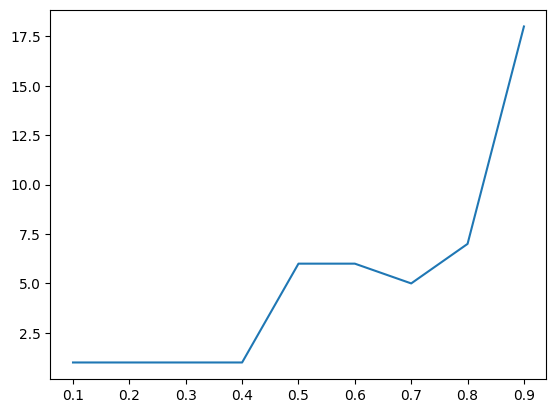

In [11]:
from matplotlib import pyplot as plt
iris = load_iris()

x = iris.data
y = iris.target
errs = []
for a in np.arange(0.1, 1, 0.1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=a, random_state=185)

    dc = NaiveBayes(x_train, y_train)
    dc.build_classifier()
    errors_count = 0
    y_pred = [dc.predict(x) for x in x_test]
    for oy_test, oy_pred in zip(y_test, y_pred):
        if oy_test != oy_pred:
            errors_count += 1
    errs.append(errors_count)
plt.plot(np.arange(0.1, 1, 0.1), errs)
plt.savefig("NavieBayes")

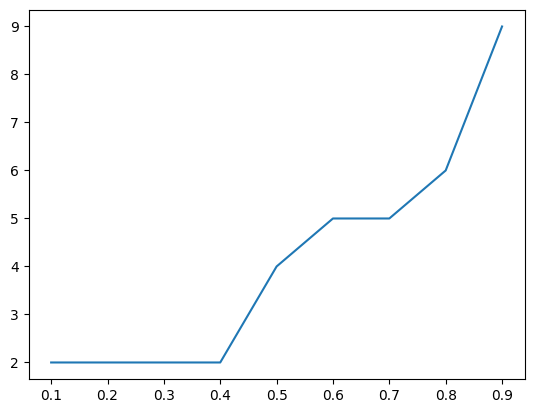

In [12]:
from matplotlib import pyplot as plt
iris = load_iris()

x = iris.data
y = iris.target
errs = []
for a in np.arange(0.1, 1, 0.1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=a, random_state=185)
    dc = GaussianNaiveBayes(x_train, y_train)
    dc.build_classifier()
    errors_count = 0
    y_pred = [dc.predict(x) for x in x_test]
    for oy_test, oy_pred in zip(y_test, y_pred):
        if oy_test != oy_pred:
            errors_count += 1
    errs.append(errors_count)
plt.plot(np.arange(0.1, 1, 0.1), errs)
plt.savefig("GaussianNavieBayes")

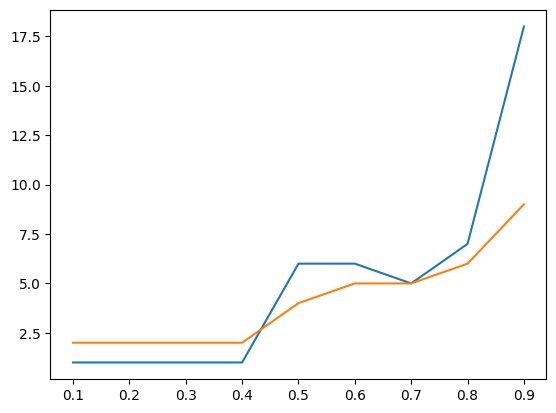

In [13]:
from matplotlib import pyplot as plt
iris = load_iris()

x = iris.data
y = iris.target
err_nb = []
err_dc = []
for a in np.arange(0.1, 1, 0.1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=a, random_state=185)

    nb = NaiveBayes(x_train, y_train)
    nb.build_classifier()

    dc = GaussianNaiveBayes(x_train, y_train)
    dc.build_classifier()

    errors_count_nb = 0
    errors_count_dc = 0
    y_pred_nb = [nb.predict(x) for x in x_test]
    y_pred_dc = [dc.predict(x) for x in x_test]
    for oy_test, oy_pred_nb, oy_pred_dc in zip(y_test, y_pred_nb, y_pred_dc):
        if oy_test != oy_pred_nb:
            errors_count_nb += 1
        if oy_test != oy_pred_dc:
            errors_count_dc += 1
    err_nb.append(errors_count_nb)
    err_dc.append(errors_count_dc)
plt.plot(np.arange(0.1, 1, 0.1), err_nb)
plt.plot(np.arange(0.1, 1, 0.1), err_dc)
plt.savefig("Comparizon")

# Wnioski
* Klasyfikatory choć mają ten sam cel, nie zawsze dobrze operują na podanych danych, jest to zależne od specyfikacji danych na których ma operować.
* Naive Bayes zakłada że wszytskie cechy danych są od siebie niezależne, natomiast Gaussian Bayes przyjmuje założenie, że dane mają rozkład normalny.
* Zakłada się, że Naive Bayes jest szybszy do wytrenowania i przewidywania.
* Zaletą Gaussian Bayes jest pewna precyzja nieosiągalna dla Naive Bayes, w pewnych sytuacjach.
* Przy wykonywaniu obliczeń na dużym zbiorze danych, rzuca się w oczy czasochłonność obliczeń, która wynika z konieczności policzenia wartości oczekiwanej oraz odchylenia standardowego.

* W operowaniu na zbiorze Iris sprawdził się lepiej Navie Bayes, jest to spowodowane specyfikacją tego konkretnego zbioru, gdzie cechy są od siebie zupełnie niezależne, a dodatkowo cechy nie rozkładają się według rozkładu normalnego.